# Task 1

In [20]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import numpy as np


dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())

data = dataset[0]

Layers: 2, Train Accuracy: 1.0000, Test Accuracy: 0.7740
Layers: 3, Train Accuracy: 1.0000, Test Accuracy: 0.7370
Layers: 4, Train Accuracy: 1.0000, Test Accuracy: 0.7490
Layers: 5, Train Accuracy: 1.0000, Test Accuracy: 0.7160
Layers: 6, Train Accuracy: 1.0000, Test Accuracy: 0.6810
Layers: 7, Train Accuracy: 1.0000, Test Accuracy: 0.7250
Layers: 8, Train Accuracy: 1.0000, Test Accuracy: 0.6570
Layers: 9, Train Accuracy: 1.0000, Test Accuracy: 0.5800
Layers: 10, Train Accuracy: 1.0000, Test Accuracy: 0.6070
Layers: 11, Train Accuracy: 0.9357, Test Accuracy: 0.5280
Layers: 12, Train Accuracy: 0.8786, Test Accuracy: 0.5240
Layers: 13, Train Accuracy: 0.4429, Test Accuracy: 0.3420


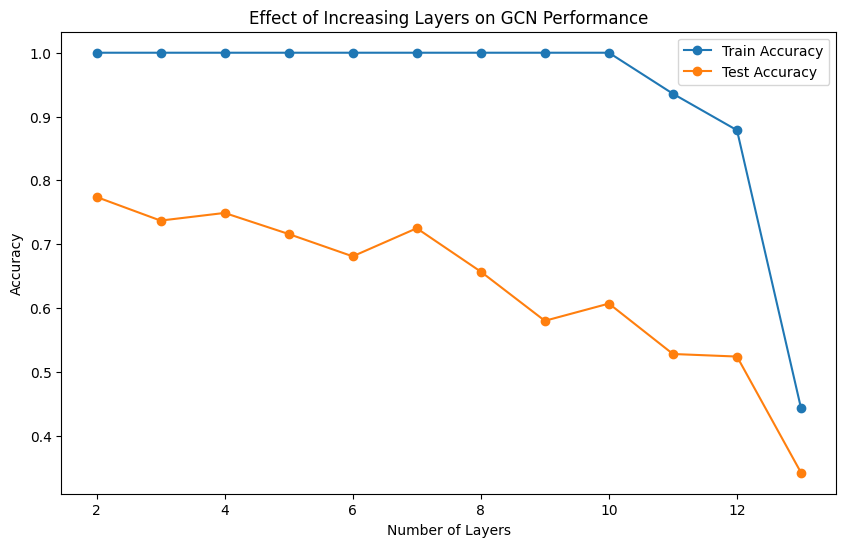

In [21]:

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(GCN, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(dataset.num_node_features, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        return self.lin(x)

def train_and_evaluate(num_layers, hidden_channels=64, epochs=200):
    model = GCN(hidden_channels=hidden_channels, num_layers=num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    return train_acc, test_acc

layer_counts = np.arange(2,14)
train_accuracies = []
test_accuracies = []

for num_layers in layer_counts:
    train_acc, test_acc = train_and_evaluate(num_layers=num_layers)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Layers: {num_layers}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(layer_counts, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(layer_counts, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.title('Effect of Increasing Layers on GCN Performance')
plt.legend()
plt.show()


Layers: 2, Train Accuracy: 1.0000, Test Accuracy: 0.7750
Layers: 3, Train Accuracy: 1.0000, Test Accuracy: 0.6850
Layers: 4, Train Accuracy: 1.0000, Test Accuracy: 0.7330
Layers: 5, Train Accuracy: 1.0000, Test Accuracy: 0.7230
Layers: 6, Train Accuracy: 1.0000, Test Accuracy: 0.7600
Layers: 7, Train Accuracy: 1.0000, Test Accuracy: 0.7500
Layers: 8, Train Accuracy: 0.9786, Test Accuracy: 0.6050
Layers: 9, Train Accuracy: 0.9000, Test Accuracy: 0.6170
Layers: 10, Train Accuracy: 0.9786, Test Accuracy: 0.6440
Layers: 11, Train Accuracy: 0.8786, Test Accuracy: 0.6150
Layers: 12, Train Accuracy: 0.4571, Test Accuracy: 0.4550
Layers: 13, Train Accuracy: 0.1429, Test Accuracy: 0.1540


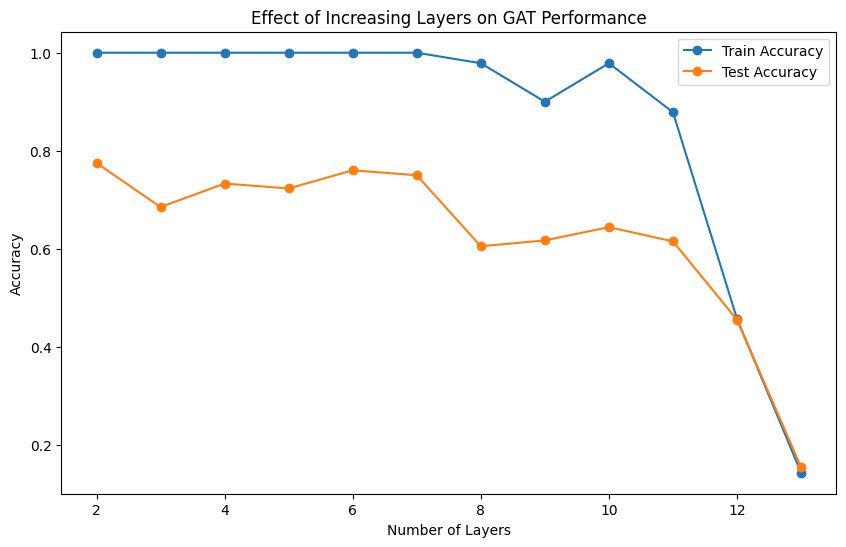

In [23]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, heads=4):
        super(GAT, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(dataset.num_node_features, hidden_channels, heads=heads, concat=True))
        
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True))
        
        self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False))
        
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        return self.lin(x)

def train_and_evaluate(num_layers, hidden_channels=64, heads=4, epochs=200):
    model = GAT(hidden_channels=hidden_channels, num_layers=num_layers, heads=heads)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    return train_acc, test_acc

layer_counts = np.arange(2, 14)
train_accuracies = []
test_accuracies = []

for num_layers in layer_counts:
    train_acc, test_acc = train_and_evaluate(num_layers=num_layers)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Layers: {num_layers}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(layer_counts, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(layer_counts, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.title('Effect of Increasing Layers on GAT Performance')
plt.legend()
plt.show()

There seems to be a overall decrease in accuracy for both models after adding extra layers. I suspect the reason is the aggregation of each node for each layer loses information. 

In [14]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch


imdb_dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
enzyme_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

import torch
from torch.utils.data import random_split, DataLoader

imdb_dataset_size = len(imdb_dataset)

train_size_imdb = int(0.7 * imdb_dataset_size)
val_size_imdb = int(0.15 * imdb_dataset_size)
test_size_imdb = imdb_dataset_size - train_size_imdb - val_size_imdb

imdb_train, imdb_val, imdb_test = random_split(imdb_dataset, [train_size_imdb, val_size_imdb, test_size_imdb])

imdb_loader = DataLoader(imdb_train, batch_size=32, shuffle=True, collate_fn=Batch.from_data_list)
imdb_val_loader = DataLoader(imdb_val, batch_size=32, shuffle=False, collate_fn=Batch.from_data_list)
imdb_test_loader = DataLoader(imdb_test, batch_size=32, shuffle=False, collate_fn=Batch.from_data_list)

In [16]:
import torch
from torch_geometric.nn import global_add_pool
from torch_geometric.utils import degree

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(torch.nn.Linear(1, hidden_channels))
        self.conv2 = GATConv(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lin = torch.nn.Linear(hidden_channels, imdb_dataset.num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)  

    def forward(self, x, edge_index, batch):
        if x is None:
            num_nodes = edge_index.max().item() + 1  
            x = torch.ones((num_nodes, 1))  
        
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)  
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  
        return self.lin(x)


In [ ]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels=1, out_channels=hidden_channels)
        self.conv2 = GATConv(in_channels=hidden_channels, out_channels=hidden_channels)
        
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)  

    def forward(self, x, edge_index, batch):
        if x is None:
            num_nodes = edge_index.max().item() + 1  
            x = torch.ones((num_nodes, 1), device=edge_index.device) 
        
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)  
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  
        return self.lin(x)

model = GAT(hidden_channels=64, out_channels=imdb_dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in imdb_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

def evaluate(loader):
    model.eval()
    correct = 0
    for batch in loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    return correct / len(loader.dataset)

imdb_acc = evaluate(imdb_loader)

print(f'IMDB Accuracy: {imdb_acc:.4f}')


IMDB Accuracy: 0.5014


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import DataLoader, Batch

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class GAT_E(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels):
        super(GAT_E, self).__init__()
        self.mlp1 = MLP(num_features, hidden_channels, hidden_channels)
        self.mlp2 = MLP(hidden_channels, hidden_channels, hidden_channels)
        
        self.conv1 = GATConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.conv2 = GATConv(in_channels=hidden_channels, out_channels=hidden_channels)
        
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.mlp1(x)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)  
        x = self.mlp2(x)
        x = self.conv2(x, edge_index).relu()
        
        x = global_mean_pool(x, batch)  
        x = self.fc(x)
        return x

model = GAT_E(num_features=3, hidden_channels=64, out_channels=6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in enzyme_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)  
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

def evaluate(loader):
    model.eval()
    correct = 0
    for batch in loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    return correct / len(loader.dataset)

enzyme_acc = evaluate(enzyme_loader)

print(f'ENZYMES Accuracy: {enzyme_acc:.4f}')


ENZYMES Accuracy: 0.2417


# Task 2

Describe one thing you found interesting in the reading. Describe what it is in your own words and why you found it interesting.

I found the concencationation of k attention (multi attention) as a way to regularization as an interesting way to limit overfitting. 

Describe one thing that you found difficult to understand. Try to be specific about what you don’t think you understand.

Why do they concatenate instead of average all k elements every layer instead of the last layer in GAT architecture. 